In [2]:
import sys

if '' in sys.path:
    sys.path.remove('')  # elimina el path actual

import torch
print(torch.__version__)


2.5.1+cu121


In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.models as models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import cv2
import numpy as np



In [4]:
# --- Configuración GPU ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)


Usando dispositivo: cuda


In [13]:
# --- Transformación base con Data Augmentation ---
transform_base = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

class AddFeaturesHSV:
    """
    Añade características extra a las imágenes de melanomas:
    - Canales HSV
    - Asimetría horizontal
    - Concatenación con RGB original
    """
    def __call__(self, img_tensor):
        # img_tensor: CxHxW (RGB)
        img_np = img_tensor.permute(1,2,0).numpy()  # HxWxC

        # --- Convertir a HSV ---
        hsv = cv2.cvtColor((img_np*255).astype(np.uint8), cv2.COLOR_RGB2HSV) / 255.0
        hsv_tensor = torch.tensor(hsv, dtype=torch.float32).permute(2,0,1)  # HxWxC -> CxHxW

        # --- Asimetría horizontal ---
        gray = cv2.cvtColor((img_np*255).astype(np.uint8), cv2.COLOR_RGB2GRAY) / 255.0
        mirror = cv2.flip(gray, 1)
        asym = np.abs(gray - mirror)
        asym = (asym - asym.min()) / (asym.max() - asym.min() + 1e-8)
        asym_tensor = torch.tensor(asym, dtype=torch.float32).unsqueeze(0)

        # --- Concatenar RGB + HSV + Asimetría ---
        return torch.cat([img_tensor, hsv_tensor, asym_tensor], dim=0)  # 7xHxW

transform_full = transforms.Compose([
    transform_base,
    AddFeaturesHSV()
])


# --- Cargar datasets ---
train_data = datasets.ImageFolder(
    root=r"C:\Users\josit\CUARTO CURSO\APRENDIZAJE AUTOMATICO\Caso1.-Detecci-n-de-melanomas\data\train",
    transform=transform_full
)
test_data = datasets.ImageFolder(
    root=r"C:\Users\josit\CUARTO CURSO\APRENDIZAJE AUTOMATICO\Caso1.-Detecci-n-de-melanomas\data\test",
    transform=transform_full
)

# --- DataLoaders ---
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

print("Clases:", train_data.classes)

Clases: ['Benign', 'Malignant']


Usando dispositivo: cuda
Epoch 1/50 | Train Loss: 0.5440 | Train Acc: 0.7267 | Val Loss: 0.6191 | Val Acc: 0.6720
Epoch 2/50 | Train Loss: 0.4893 | Train Acc: 0.7642 | Val Loss: 0.5149 | Val Acc: 0.7235
Epoch 3/50 | Train Loss: 0.4500 | Train Acc: 0.7902 | Val Loss: 0.4865 | Val Acc: 0.7675
Epoch 4/50 | Train Loss: 0.4382 | Train Acc: 0.8007 | Val Loss: 0.4653 | Val Acc: 0.7775
Epoch 5/50 | Train Loss: 0.4081 | Train Acc: 0.8155 | Val Loss: 0.4400 | Val Acc: 0.7945
Epoch 6/50 | Train Loss: 0.3921 | Train Acc: 0.8272 | Val Loss: 0.4105 | Val Acc: 0.8170
Epoch 7/50 | Train Loss: 0.3753 | Train Acc: 0.8356 | Val Loss: 0.4703 | Val Acc: 0.7780
Epoch 8/50 | Train Loss: 0.3678 | Train Acc: 0.8391 | Val Loss: 0.3955 | Val Acc: 0.8155
Epoch 9/50 | Train Loss: 0.3642 | Train Acc: 0.8431 | Val Loss: 0.4341 | Val Acc: 0.7845
Epoch 10/50 | Train Loss: 0.3528 | Train Acc: 0.8420 | Val Loss: 0.4100 | Val Acc: 0.8085
Epoch 11/50 | Train Loss: 0.3489 | Train Acc: 0.8419 | Val Loss: 0.3514 | Val Acc: 0

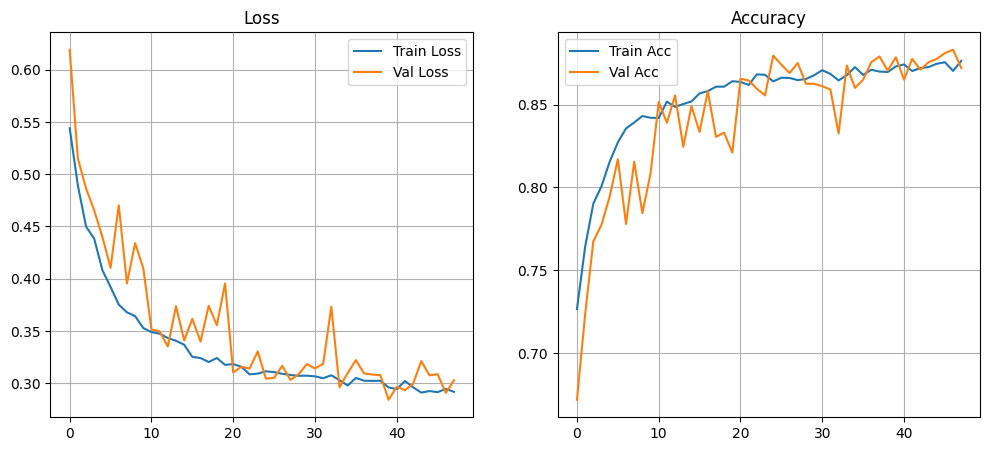

In [19]:

# --- Configuración GPU ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)


# --- Modelo CNN más profundo ---
class CNNFeatures(nn.Module):
    def __init__(self, num_classes):
        super(CNNFeatures, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(7, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),


            nn.AdaptiveAvgPool2d((1,1))
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    
    def forward(self,x):
        x = self.features(x)
        x = torch.flatten(x,1)
        x = self.classifier(x)
        return x

model = CNNFeatures(len(train_data.classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# --- Entrenamiento con early stopping ---
num_epochs = 50
patience = 8
best_val_loss = float('inf')
counter = 0

train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
best_model_state = None

for epoch in range(num_epochs):
    model.train()
    running_loss, correct_train, total_train = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device).float(), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        correct_train += (outputs.argmax(1) == labels).sum().item()
        total_train += labels.size(0)
    
    train_loss = running_loss / len(train_loader.dataset)
    train_acc = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    # --- Validación ---
    model.eval()
    val_loss, correct_val, total_val = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device).float(), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            correct_val += (outputs.argmax(1) == labels).sum().item()
            total_val += labels.size(0)
    val_loss /= len(test_loader.dataset)
    val_acc = correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        counter = 0
    else:
        counter +=1
        if counter >= patience:
            print(f"⛔ Early stopping en epoch {epoch+1}")
            break

# --- Guardar mejor modelo ---
if best_model_state:
    torch.save({
        'model_state': best_model_state,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies
    }, 'best_model_features.pth')

# --- Graficar Accuracy y Loss ---
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend(); plt.grid(True); plt.title("Loss")
plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.legend(); plt.grid(True); plt.title("Accuracy")
plt.show()


In [24]:
model.eval()  # modo evaluación
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.float()
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)  # la clase con mayor probabilidad
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


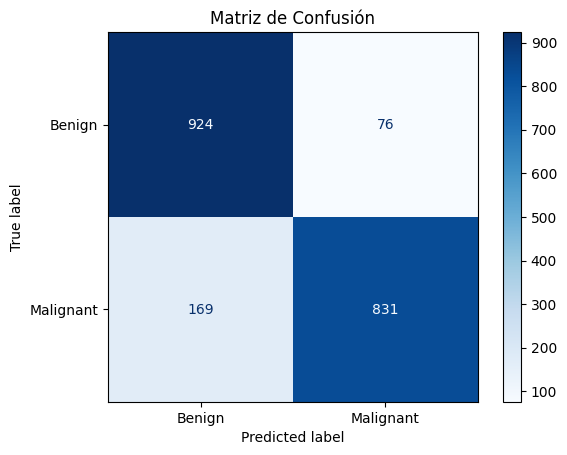

In [25]:
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_data.classes)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión")
plt.show()


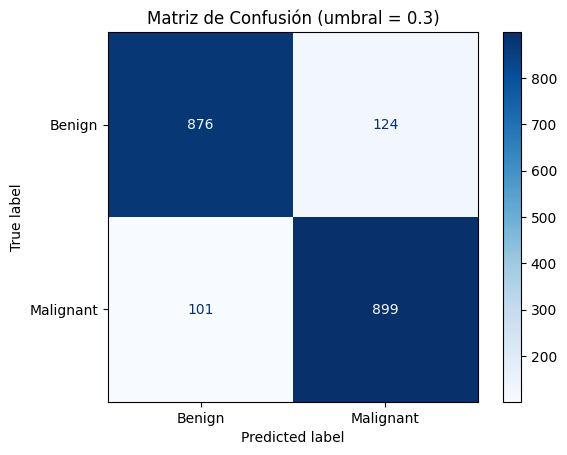

In [ ]:
model.eval()
all_preds = []
all_labels = []

umbral = 0.3   
# Ejemplo: 0.5 = normal, 0.4 = más propenso a decir "maligno"

with torch.no_grad():
    for images, labels in test_loader:
        images = images.float().to(device)
        labels = labels.to(device)

        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)  # convierte logits en probabilidades

        # Probabilidad de la clase "malignant" (índice 1)
        malignant_probs = probs[:, 1]

        # Predicción personalizada según umbral
        preds = (malignant_probs > umbral).long()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# --- Matriz de confusión ---
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_data.classes)
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Matriz de Confusión (umbral = {umbral})")
plt.show()
